# Spatial Analytics with PySAL on top of Uber's H3 geographies

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline

import pysal
import pandas
import geopandas
import contextily as cx
from h3 import h3
from shapely.geometry import Polygon

H3_ZOOM = 8

## Load data

In [4]:
url = ("https://raw.githubusercontent.com/gdsbook/book/master/data/tokyo/tokyo_clean.csv")
db = pandas.read_csv(url)

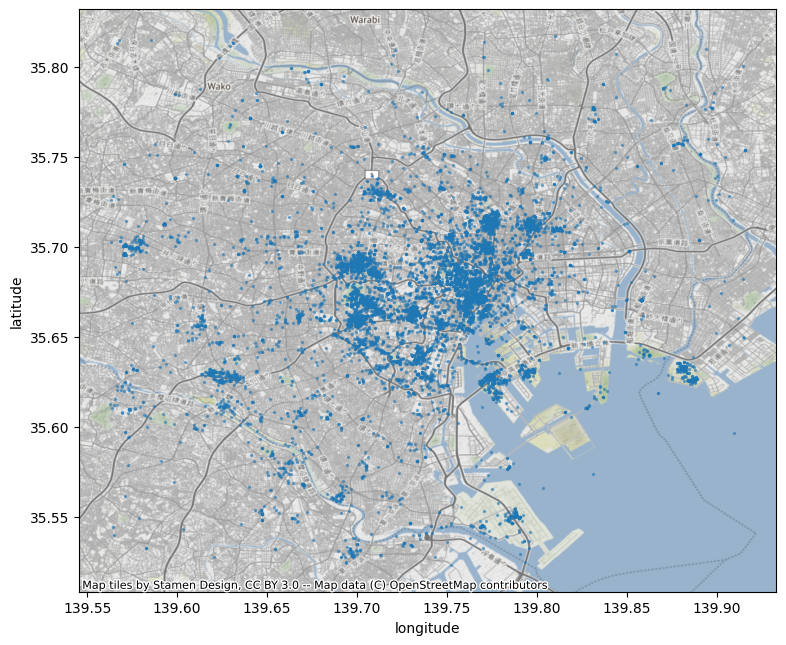

In [5]:
ax = db.plot.scatter("longitude", "latitude", 
                     s=2, alpha=0.5,
                     figsize=(9, 9))
cx.add_basemap(ax, crs={'init': 'epsg:4326'},
               url=cx.providers.CartoDB.DarkMatter)

## Turn points into H3 hexagons

### Get `h3` addresses for the extent of the map:

* Get all `h3` hexs in the bounding box

In [6]:
e, s, w, n = db.describe()\
               .loc[['min', 'max'], 
                    ['longitude', 'latitude']]\
               .values\
               .flatten()
bb_gjson = {'type': 'Polygon',
            'coordinates': (((e, s), (w, s), 
                             (w, n), (e, n), 
                             (e, s)),)}

In [9]:
s

35.523416

In [10]:
all_hexs = h3.polyfill(bb_gjson, 
                       H3_ZOOM, 
                       geo_json_conformant=True)
len(all_hexs)

1536

* Obtain geometries

In [11]:
polygonise = lambda hex_id: Polygon(
                                h3.h3_to_geo_boundary(
                                    hex_id, geo_json=True)
                                    )

%time all_polys = geopandas.GeoSeries(list(map(polygonise, all_hexs)), \
                                      index=all_hexs, \
                                      crs={'init': 'epsg:4326'})

CPU times: user 59 ms, sys: 26.4 ms, total: 85.4 ms
Wall time: 83.7 ms


/home/laia/.pyenv/versions/3.8.12/envs/livablestreetsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Get `h3` addresses for areas with pics

In [12]:
h3fy = lambda r: h3.geo_to_h3(r['latitude'], r['longitude'], H3_ZOOM)
db['h3hex'] = db[['longitude', 'latitude']].apply(h3fy, axis=1)

In [13]:
polys_w_pics = db.groupby('h3hex').size()
polys_w_pics.head()

h3hex
882f5a048dfffff    1
882f5a04b9fffff    1
882f5a04d1fffff    1
882f5a04d5fffff    1
882f5a04d7fffff    1
dtype: int64

* Join counts to geometries

In [14]:
polys_db = geopandas.GeoDataFrame({'geometry': all_polys,
                                   'pic_count': 0},
                                  crs=all_polys.crs)
polys_db['pic_count'].update(polys_w_pics)
polys_db.head()

,geometry,pic_count
882f5a3487fffff,"POLYGON ((139.57439 35.72907, 139.57467 35.733...",0
882f5a3355fffff,"POLYGON ((139.87571 35.73845, 139.87601 35.743...",1
882f5a3709fffff,"POLYGON ((139.71382 35.70573, 139.71411 35.710...",3
882f5a30e5fffff,"POLYGON ((139.77433 35.77393, 139.77463 35.778...",0
882f5aaf53fffff,"POLYGON ((139.81915 35.58344, 139.81945 35.588...",0


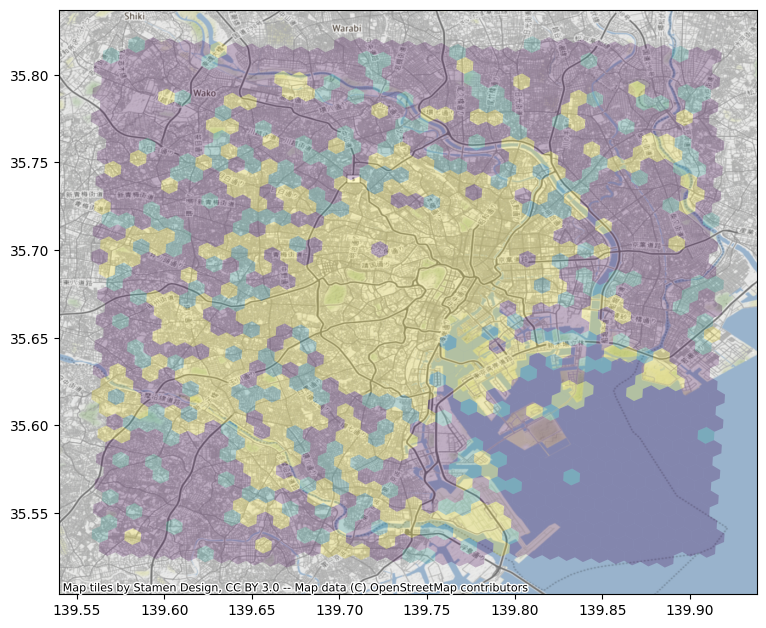

In [15]:
ax = polys_db.plot(column='pic_count', 
                   scheme='quantiles', k=3, 
                   alpha=0.25, figsize=(9, 9))
cx.add_basemap(ax, crs=polys_db.crs, 
               url=cx.providers.CartoDB.DarkMatter);

## Build a Spatial Weights Matrix

* **Option A**: using a `GeoDatraFrame`

https://pysal.org/notebooks/lib/libpysal/Example_Datasets.html

In [26]:
%time w_gpd = libpysal.weights.Queen.from_dataframe(polys_db)

CPU times: user 202 ms, sys: 8.66 ms, total: 211 ms
Wall time: 207 ms


In [28]:
w_gpd.neighbors

{0: [948, 1480, 1384, 921, 14],
 1: [1376, 1153, 883, 301, 766, 1151],
 2: [1184, 1235, 391, 296, 648, 351],
 3: [738, 1109, 998, 248, 140, 1245],
 4: [641, 1489, 1161, 218, 43, 668],
 5: [432, 131, 1082, 1030, 42, 30],
 6: [457, 622, 982],
 7: [1091, 964, 1383, 1163, 860, 957],
 8: [896, 306, 163, 441, 684, 590],
 9: [1296, 224, 179],
 10: [928, 995, 868, 1078, 311, 1179],
 11: [1472, 611, 167, 744, 699, 751],
 12: [608, 240, 773, 647, 760, 1534],
 13: [194, 938, 1083, 924, 1502, 1199],
 14: [0, 1384, 765],
 15: [1409, 1042, 1319, 360, 749, 46],
 16: [160, 656, 1475, 279, 1320, 1165],
 17: [994, 916, 294, 1079, 776, 1231],
 18: [1180, 775, 1420, 375, 1532, 1071],
 19: [1183, 690, 1255, 697, 1003, 1263],
 20: [243, 1444, 728, 1451, 667, 877],
 21: [976, 1005, 518, 1418, 1453, 1327],
 22: [1441, 898, 114, 1522, 438, 1305],
 23: [1145, 1298, 665, 1224, 1497, 1499],
 24: [468, 662, 583, 1064, 825, 748],
 25: [992, 315, 1206, 587, 396, 1182],
 26: [1157, 54, 1113, 985, 350, 207],
 27: [137

* **Option B**: using H3's `kRing`

In [46]:
def w_from_hids(hids):
    shids = set(hids)
    neis = {}
    for hid in hids:
        neis[hid] = list(h3.k_ring(hid, 1).intersection(shids))
    w = libpysal.weights.W(neis, id_order=hids, ids=hids)
    return w

%time w_h3 = w_from_hids(polys_db.index.tolist())

CPU times: user 57.4 ms, sys: 10.4 ms, total: 67.9 ms
Wall time: 64.1 ms


In [47]:
# creating weighted matrix from h3 weights
import libpysal

In [48]:
w_h3.neighbors

<1536x1536 sparse matrix of type '<class 'numpy.float64'>'
	with 27702 stored elements in Compressed Sparse Row format>

<AxesSubplot: >

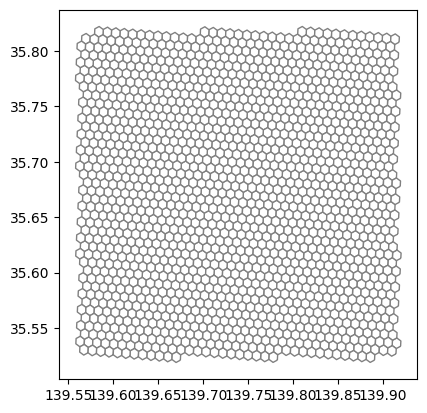

In [49]:
polys_db.plot(edgecolor='grey', facecolor='w')

/home/laia/.pyenv/versions/3.8.12/envs/livablestreetsenv/lib/python3.8/site-packages/libpysal/weights/weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/laia/.pyenv/versions/3.8.12/envs/livablestreetsenv/lib/python3.8/site-packages/libpysal/weights/weights.py:1296: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/laia/.pyenv/versions/3.8.12/envs/livablestreetsenv/lib/python3.8/site-packages/libpysal/weights/weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/laia/.pyenv/ve

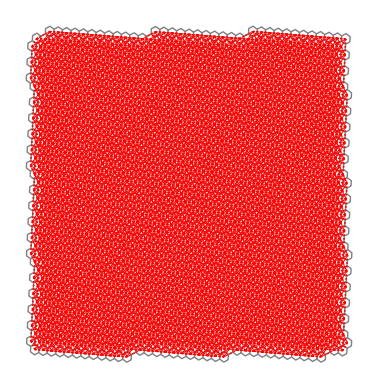

In [50]:
ax = polys_db.plot(edgecolor='grey', facecolor='w')
f,ax = w_h3.plot(polys_db, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

